# Network Distance with LION map
We will attempt to use networkx library with the lion map to calculate network distance for people walking between two points
- Download the zipfile
- Extract and save the zipfile
- Open the line shapefile
- Extract nodes
- Calculate network distance!

In [39]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from shapely.geometry import box, LineString, Point,MultiPoint
import pyproj
import os
import sys
import requests
from zipfile import ZipFile as zzip
import fiona
import pprint
from fiona import collection
from scipy.spatial import cKDTree
import numpy as np

sys.path.append(os.path.realpath('..'))

In [2]:
os.getcwd()

'H:\\Personal\\Network distance'

In [3]:
print(fiona.__version__)

1.8.6


## Downloading and Extracting the NYC Lion file
- This does not need to be run repeatedly

In [20]:
url = r"https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyclion_19b.zip"
# download the file contents in binary format
r = requests.get(url)
# open method to open a file on your system and write the contents
with open("./input_data/nyclion_19b.zip", "wb") as file:
    file.write(r.content)

In [21]:
file_name = "./input_data/nyclion_19b.zip"

In [22]:
# opening the zip file in READ mode 
with zzip(file_name, 'r') as file: 
    # printing all the contents of the zip file 
    file.printdir() 
  
    # extracting all the files 
    #rint('Extracting all the files now...') 
    file.extractall("./input_data/") 
    print('Done!')

File Name                                             Modified             Size
lion/lion.gdb/a00000001.freelist               2019-05-13 12:48:56         4440
lion/lion.gdb/a00000001.gdbindexes             2019-05-13 12:42:56          110
lion/lion.gdb/a00000001.gdbtable               2019-05-13 12:48:56          385
lion/lion.gdb/a00000001.gdbtablx               2019-05-13 12:48:56         5152
lion/lion.gdb/a00000001.TablesByName.atx       2019-05-13 12:48:56         4118
lion/lion.gdb/a00000002.gdbtable               2019-05-13 12:42:56         2055
lion/lion.gdb/a00000002.gdbtablx               2019-05-13 12:42:56         5152
lion/lion.gdb/a00000003.gdbindexes             2019-05-13 12:42:56           42
lion/lion.gdb/a00000003.gdbtable               2019-05-13 12:44:22         1825
lion/lion.gdb/a00000003.gdbtablx               2019-05-13 12:44:22         5152
lion/lion.gdb/a00000004.CatItemsByPhysicalName.atx 2019-05-13 12:48:56         4118
lion/lion.gdb/a00000004.CatItemsByTy

Get layers from GDB

In [4]:
gdb_file = r"./input_data/lion/lion.gdb"
layers = fiona.listlayers(gdb_file)

View the layers

In [5]:
for layer in layers:
    print(layer)

node
node_stname
altnames
lion


# Open the lion node layer as geopandas dataframe

In [6]:
node_gdf = gpd.read_file(gdb_file, driver='FileGDB', layer='node')

In [8]:
node_gdf.crs

{'init': 'epsg:2263'}

In [9]:
node_gdf = node_gdf.to_crs({'init': 'epsg:4326'})

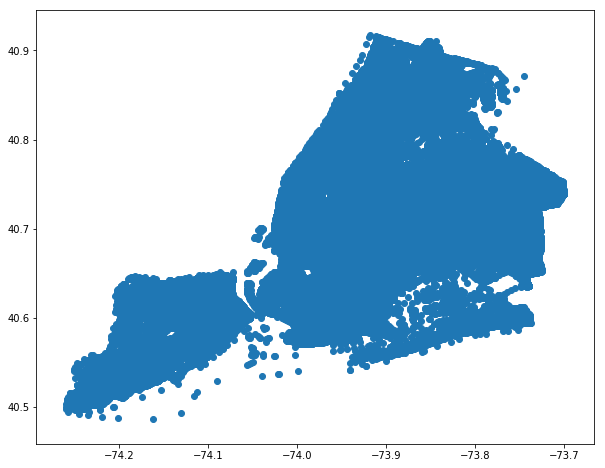

In [10]:
node_gdf.plot(figsize=(10,10));

In [11]:
node_gdf.head()

,NODEID,VIntersect,geometry
0,1,,POINT (-74.25702151185867 40.49414563819848)
1,2,,POINT (-74.2444384925972 40.4922776914055)
2,3,,POINT (-74.25874354305616 40.49704148607952)
3,4,,POINT (-74.25874745972354 40.50270602375194)
4,5,,POINT (-74.25850081677105 40.50810821233414)


## Open the lion layer
It was impossible to read in this layer with the old version of `Fiona`. Please ensure that your `Fiona` version is the most up to date.

In [12]:
lion_gdf = gpd.read_file(gdb_file, driver='FileGDB', layer='lion')

In [14]:
lion_gdf.crs

{'init': 'epsg:2263'}

In [15]:
lion_gdf = lion_gdf.to_crs({'init': 'epsg:4326'})

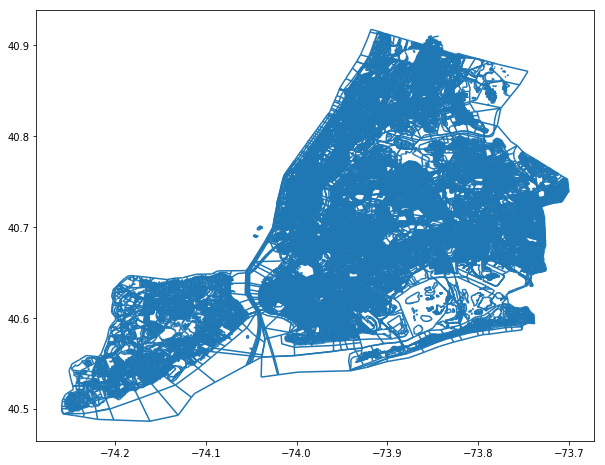

In [16]:
lion_gdf.plot(figsize = (10,10));

In [17]:
lion_gdf.head()

,Street,SAFStreetName,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,SpecAddr,...,LHi_Hyphen,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,SHAPE_Length,geometry
0,EAST 168 STREET,,0,U,,B,,T,DOT,,...,699,596,716,599,699,596,716,2251001000000,396.030947,(LINESTRING (-73.90346685871668 40.83035379646...
1,WEST 192 STREET,,0,U,,B,,A,DOT,,...,98,63,99,58,98,63,99,2798401000000,279.360514,(LINESTRING (-73.9012006771837 40.866613078249...
2,UNION AVENUE,,0,U,,B,,W,DOT,,...,1079,1016,1084,1017,1079,1016,1084,2728001000000,618.327133,(LINESTRING (-73.90117669122948 40.82438890917...
3,UNION AVENUE,BEHAGEN PLAYGROUND,0,U,,B,,W,DOT,N,...,None,None,None,0,0,0,0,21279501000000N,618.327133,(LINESTRING (-73.90117669122948 40.82438890917...
4,DELAFIELD AVENUE,,6,U,,B,,T,DOT,,...,4645,4600,4664,4601,4645,4600,4664,2187601000000,670.281037,(LINESTRING (-73.90695663477764 40.89360793519...


### Save the lion layer as a shapefile

In [65]:
fp = r"./intermediate_data/lion_line.shp"
lion_gdf.to_file(fp)

## Test case
We will use two points that are across from each other, but has a highway between them. The network analysis route should move along the road until it find a road that can cross under the highway.

To see the points:
Destination point: https://www.google.com/maps/place/40%C2%B044'13.9%22N+73%C2%B051'50.6%22W/@40.737199,-73.8662467,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x0!8m2!3d40.737199!4d-73.864058

Origin point: 
https://www.google.com/maps/place/40%C2%B043'56.9%22N+73%C2%B051'42.0%22W/@40.732484,-73.8638547,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x0!8m2!3d40.732484!4d-73.861666

In [18]:
target_xy = (40.737199,-73.864058)
orig_xy = (40.732484,-73.861666)

In [66]:
fp = r"./intermediate_data/lion_line.shp"
lion_graph = nx.read_shp(fp)

In [20]:
lion_graph

MemoryError: 

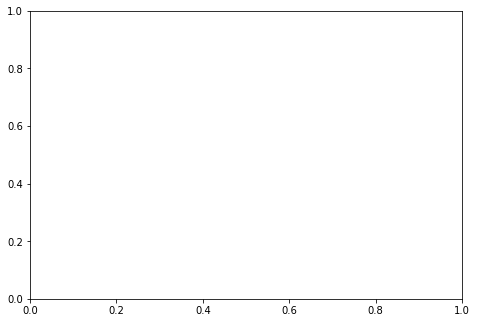

In [84]:
nx.draw(lion_graph)
plt.draw()
plt.show()

Writing the Graph to shapefile creates the nodes and edges

In [67]:
fp = r"./intermediate_data"
nx.write_shp(lion_graph, fp)

Read the node and edges as geopandas dataframes

In [68]:
fp = r"./intermediate_data/nodes.shp"
node_gdf = gpd.read_file(fp)

In [70]:
node_gdf.crs = {'init': 'epsg:4326'}

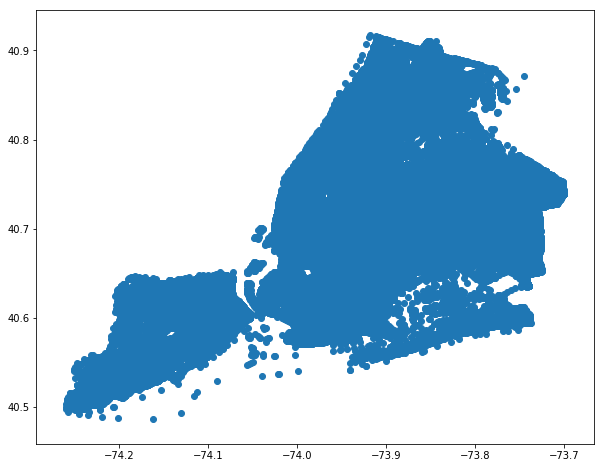

In [71]:
node_gdf.plot(figsize=(10,10));

In [72]:
node_gdf['x'] = node_gdf['geometry'].x
node_gdf['y'] = node_gdf['geometry'].y

In [73]:
node_gdf.head()

,FID,geometry,x,y
0,0,POINT (-73.90346685871668 40.83035379646685),-73.903467,40.830354
1,1,POINT (-73.9023800533195 40.82964662740077),-73.902380,40.829647
2,2,POINT (-73.9012006771837 40.86661307824997),-73.901201,40.866613
3,3,POINT (-73.90207336386543 40.86699910556131),-73.902073,40.866999
4,4,POINT (-73.90117669122948 40.82438890917424),-73.901177,40.824389


In [77]:
#target_xy = (40.737199,-73.864058)
#orig_xy = (40.732484,-73.861666)

target_xy = (-73.864058, 40.737199)
orig_xy = (-73.861666,40.732484)

In [78]:
nB = np.array(list(zip(node_gdf.geometry.x, node_gdf.geometry.y)) )
btree = cKDTree(nB)

In [79]:
dist, target_node = btree.query(target_xy,k=1)
print(dist, target_node)

3.7438436323677245e-05 82730


In [80]:
dist, orig_node = btree.query(orig_xy,k=1)
print(dist, orig_node)

2.6730270855641812e-05 94665


In [81]:
node_gdf['geometry'].loc[node_gdf['FID'] == 82730]

82730    POINT (-73.86404739259665 40.73716309568955)
Name: geometry, dtype: object

In [82]:
route = nx.shortest_path(G=lion_graph, source=orig_node, target=target_node, weight=None)

NodeNotFound: Either source 94665 or target 82730 is not in G